<a href="https://colab.research.google.com/github/Rohan5076/AIMLOPS/blob/main/Final_M2_NB_MiniProject_2_DeepLabV3%2B_Lungs_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Programme in AI and MLOps
## A programme by IISc and TalentSprint
### Mini-Project: Lung Segmentation of Chest X-Ray dataset using DeepLabV3+

## Introduction

Semantic segmentation is a computer vision task that involves dividing an image into different regions, each of which is labeled with a semantic category. The goal of semantic segmentation is to enable machines to understand the content of an image at a pixel level, by assigning a label to each individual pixel based on the object or region it belongs to.

This technique is widely used in many applications such as self-driving cars, medical image analysis, and object recognition in robotics. It helps to extract meaningful information from images and to understand the relationships between objects and their environment.

The below figure shows how semantic segmentation differs from other algorithms, such as object detection.

<br>
<img src='https://cdn.iisc.talentsprint.com/AIandMLOps/Images/segmentation_vs_other_algos.jpeg' width=700px>
<br><br>

Moreover, in contrast to object detection, which detects and localizes objects within an image, semantic segmentation is more precise and detailed. It provides a much more granular understanding of the content of an image, allowing for more advanced and accurate applications.

## Dataset

*  The Chest X-Ray dataset is made up of images and segmentated mask from two diffrent sources - Shenzhen and Montgomery dataset
*  The CXR_png folder consists of Chest X-Rays and the masks folder has the segmented mask
*  There are 704 images with their masks mapped with each other  

<br>
$\quad$<img src='https://cdn.extras.talentsprint.com/AIandMLOps/Images/semantic_segmentation.png' width=700px>
<br><br>


## Problem Statement

Perfrom the lungs segmentation on Chest X-Ray dataset using DeepLabV3+ model.

## Grading = 10 Points

In [ ]:
#@title Download the data
!wget https://cdn.iisc.talentsprint.com/AIandMLOps/MiniProjects/Datasets/LungSegmentation.zip
!unzip -qq LungSegmentation.zip
print("Data Downloaded Successfuly!!")

--2024-06-08 04:14:04--  https://cdn.iisc.talentsprint.com/AIandMLOps/MiniProjects/Datasets/LungSegmentation.zip
Resolving cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)... 172.105.52.210
Connecting to cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)|172.105.52.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139904834 (133M) [application/zip]
Saving to: ‘LungSegmentation.zip’

LungSegmentation.zi 100%[===================>] 133.42M  47.9MB/s    in 2.8s    

2024-06-08 04:14:08 (47.9 MB/s) - ‘LungSegmentation.zip’ saved [139904834/139904834]

Data Downloaded Successfuly!!


### Import required packages

In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from PIL import Image
from scipy.io import loadmat
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### **PART-A**

### Data Visualization (1 point)

#### Image Visualization
Visualize one of the Chest X-Ray image and its segmented label image.

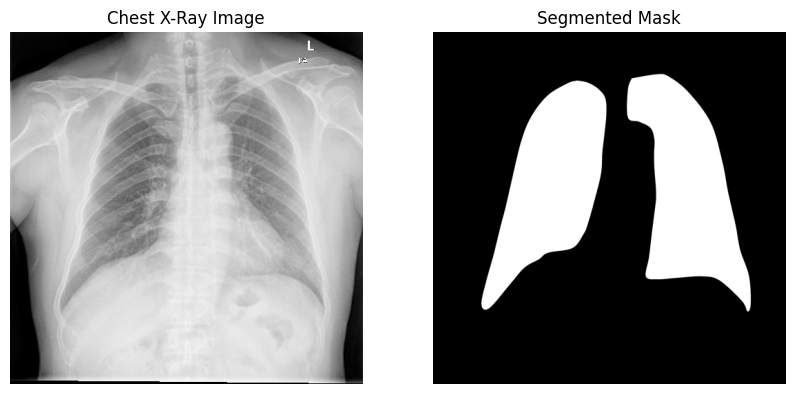

In [ ]:
# Visualize an image

image_path = '/content/LungSegmentation/CXR_png/CHNCXR_0001_0.png'
mask_path = '/content/LungSegmentation/masks/CHNCXR_0001_0.png'

# Load the image and the mask
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Assuming the X-Ray images are grayscale
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Assuming the masks are also grayscale

# Function to visualize an image and its mask
def visualize_image_and_mask(image, mask):
    plt.figure(figsize=(10, 5))

    # Display the image
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Chest X-Ray Image')
    plt.axis('off')

    # Display the mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Segmented Mask')
    plt.axis('off')

    plt.show()

# Visualize the image and mask
visualize_image_and_mask(image, mask)

<ipython-input-4-5d7084e7cdd6>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet')


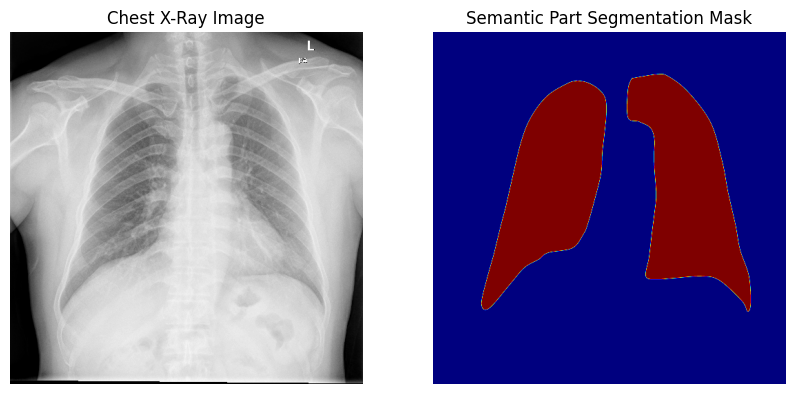

In [ ]:
# Visualize a semantic part segmentation label image
# Paths to the image and the corresponding mask
# Load the image and the mask
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Assuming the X-Ray images are grayscale
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Assuming the masks are also grayscale

# Function to visualize an image and its semantic segmentation mask
def visualize_semantic_segmentation(image, mask):
    # Define a colormap for visualization
    colormap = plt.cm.get_cmap('jet')

    # Normalize the mask to the range 0-1
    normalized_mask = mask / np.max(mask)

    # Apply the colormap to the mask
    colored_mask = colormap(normalized_mask)

    # Remove the alpha channel
    colored_mask = (colored_mask[:, :, :3] * 255).astype(np.uint8)

    plt.figure(figsize=(10, 5))

    # Display the image
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Chest X-Ray Image')
    plt.axis('off')

    # Display the mask
    plt.subplot(1, 2, 2)
    plt.imshow(colored_mask)
    plt.title('Semantic Part Segmentation Mask')
    plt.axis('off')

    plt.show()

# Visualize the image and mask
visualize_semantic_segmentation(image, mask)


### Create a TensorFlow Dataset (1 points)
Use the image size, batch size, number of classes, and data directory as given in the below code cell.

Hint:
1. Find all the image files in the CXR_png and masks subdirectory separately. The resulting list should be sorted in ascending order.
2. Create a list of validation image, validation masks, test image, test masks, etc.
3. Create a function that reads an image file and returns a preprocessed image tensor.  

In [ ]:
from glob import glob
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 2
DATA_DIR = "./LungSegmentation"

# Find paths for all the image files in the 'CXR_png' subdirectory of the DATA_DIR directory.
# Sort the list of file paths in ascending order
all_images = sorted(glob(os.path.join(DATA_DIR, 'CXR_png', '*.png')))

# Find paths for all the mask files in the 'masks' subdirectory of the DATA_DIR directory.
# Sort the list of file paths in ascending order
all_masks = sorted(glob(os.path.join(DATA_DIR, 'masks', '*.png')))

# Define a split ratio
val_split = 0.2
test_split = 0.1

# Total number of images
total_images = len(all_images)

# Split indices
val_count = int(total_images * val_split)
test_count = int(total_images * test_split)



# Create a list of validation image files
val_images =  all_images[:val_count]

# Create a list of validation mask files
val_masks = all_masks[:val_count]


# Create a list of test image files
test_images = all_images[val_count:val_count + test_count]

# Create a list of test mask files
test_masks =all_masks[val_count:val_count + test_count]


# Create a list of train image files
train_images =all_images[val_count + test_count:]
# Create a list of train mask files
train_masks = all_masks[val_count + test_count:]


In [ ]:
# Function to read an image file and returns a preprocessed image tensor.
# The mask argument is set to False by default, indicating that it is an image file, not a mask file.

def read_image(image_path, mask=False):
    # Read the file
    image = tf.io.read_file(image_path)

    # Decode the image
    if mask:
        image = tf.image.decode_png(image, channels=1)  # Masks are single channel (grayscale)
    else:
        image = tf.image.decode_png(image, channels=3)  # Images are three channels (RGB)

    # Resize the image
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])

    # Normalize the image
    image = tf.cast(image, tf.float32)
    image = image / 255.0  # Normalize to range [0, 1]

    return image


Create a **load_data** function that takes in two arguments, **image_list** and **mask_list**, which are lists of file paths to the images and corresponding masks, respectively. It then reads in the image and mask using the **read_image** function defined earlier. The function returns a tuple of **image** and **mask**.

In [ ]:
DATA_DIR = "./LungSegmentation"

# Function to load data given lists of image and mask file paths
def load_data(image_list, mask_list):
    images = []
    masks = []

    for img_path, mask_path in zip(image_list, mask_list):
        image = read_image(img_path, mask=False)
        mask = read_image(mask_path, mask=True)
        images.append(image)
        masks.append(mask)

    # Convert lists to tensors
    images = tf.stack(images)
    masks = tf.stack(masks)

    return images, masks

# Find all image and mask files
all_images = sorted(glob(os.path.join(DATA_DIR, 'CXR_png', '*.png')))
all_masks = sorted(glob(os.path.join(DATA_DIR, 'masks', '*.png')))

# Ensure the lists are not empty
assert all_images, "No images found in the specified directory."
assert all_masks, "No masks found in the specified directory."

# Example usage: load all data
images, masks = load_data(all_images, all_masks)

print("Images shape:", images.shape)
print("Masks shape:", masks.shape)


Images shape: (704, 512, 512, 3)
Masks shape: (704, 512, 512, 1)


Create a **data_generator** function that takes in **image_list** and **mask_list** as arguments.

The function should:
- create a **tf.data.Dataset** object from the input data
- map the **load_data** function to each element in the dataset
- convert the dataset into batches of size **BATCH_SIZE**, drop any incomplete batch at the end of the dataset
- return the resulting dataset

In [ ]:
# Generate train and validation set
IMAGE_SIZE = 512
BATCH_SIZE = 4
DATA_DIR = "./LungSegmentation"
def data_generator(image_list, mask_list):
  # Create a tf.data.Dataset object from the input data
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))

    # Map the load_data function to each element in the dataset
    dataset = dataset.map(lambda img, mask: (read_image(img, mask=False), read_image(mask, mask=True)),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Batch the dataset and drop any incomplete batch
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

    # Prefetch to improve performance
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

# Split the data into training and validation sets
split_index = int(0.8 * len(all_images))
train_images = all_images[:split_index]
train_masks = all_masks[:split_index]
val_images = all_images[split_index:]
val_masks = all_masks[split_index:]


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print(f"Train dataset: {train_dataset}")
print(f"Validation dataset: {val_dataset}")

Train dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>
Validation dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>


Check the total images for train and validation.

In [ ]:
total_train_images = len(train_images)
total_val_images = len(val_images)

print(f"Total training images: {total_train_images}")
print(f"Total validation images: {total_val_images}")


Total training images: 563
Total validation images: 141


Check the number of batches formed in train and validation set.


In [ ]:
num_train_batches = tf.data.experimental.cardinality(train_dataset).numpy()
num_val_batches = tf.data.experimental.cardinality(val_dataset).numpy()

print(f"Number of batches in train set: {num_train_batches}")
print(f"Number of batches in validation set: {num_val_batches}")

Number of batches in train set: 140
Number of batches in validation set: 35


Now, we have created our TensorFlow Dataset. Further, let us try to understand the DeepLabV3+ model.

### **PART-B**

### Building the DeepLabV3+ model

Downsampling is widely adopted in deep convolutional neural networks (CNN) for reducing memory consumption while preserving the transformation invariance to some degree.

Multiple downsampling of a CNN will lead the feature map resolution to become smaller, resulting in lower prediction accuracy and loss of boundary information in semantic segmentation.

DeepLabv3+ helps in solving these issues by including **atrous convolutions**. They aggregate context around a feature which helps in segmenting it better.

<br>

#### **Atrous Convolution/Dilated Convolution**

It is a tool for refining the effective field of view of the convolution. It modifies the field of view using a parameter termed ***atrous rate*** or ***dilation rate***.

With dilated convolution, as we go deeper in the network, we can keep the stride constant but with larger field-of-view without increasing the number of parameters or the amount of computation. It also enables larger output feature maps, which is useful for semantic segmentation.

In the below figure, Atrous/Dilated Convolution has wider field of view with same number of parameters as Normal convolution.

<br>
<img src="https://cdn.iisc.talentsprint.com/AIandMLOps/Images/Dilated_Conv.jpg" width=500px>
<br><br>



#### **DeepLabv3+**

Earlier version, DeepLabv3 has a problem of consuming too much time to process high-resolution images. DeepLabv3+ is a semantic segmentation architecture that improves upon DeepLabv3 with several improvements, such as adding an effective decoder module to refine the segmentation results.

The below figure shows the typical architecture of DeepLabv3+. The encoder module processes multiscale contextual information by applying dilated/atrous convolution at multiple scales, while the decoder module refines the segmentation results along object boundaries.

<br>
<img src="https://cdn.iisc.talentsprint.com/AIandMLOps/Images/deeplabv3_plus_model.png" width=1000px>
<br><br>

Deeplabv3+ employs Aligned Xception network as its main feature extractor (encoder), although with substantial modifications. Depth-wise separable convolution replaces all max pooling procedures.

In Model Playground, we can select feature extraction (encoding) network to use as either **Resnet** or EfficientNet.

The reason for using **Dilated Spatial Pyramid Pooling** is that it was shown that as the sampling rate becomes larger, the number of valid filter weights (i.e., weights that are applied to the valid feature region, instead of padded zeros) becomes smaller.


### Create the model (5 points)
First, create different functions  to implement DeepLabV3+ architecture.



Create a function, **convolution_block()**, to add a convolution layer, a BatchNormalization layer, and apply ReLu activation in one go.

In [ ]:
from tensorflow.keras.layers import UpSampling2D, Concatenate, Conv2D, BatchNormalization, ReLU

def convolution_block(inputs, filters, kernel_size, strides=1, padding='same', dilation_rate=1):

    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, dilation_rate=dilation_rate)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

Create another function to perform **Dilated Spatial Pyramid Pooling**. Use above function to add different convolution blocks.

In [ ]:
def dilated_spatial_pyramid_pooling(inputs, filters):
    """
    Applies Dilated Spatial Pyramid Pooling (ASPP) to the input tensor.

    Args:
    inputs (tensor): Input tensor to the ASPP block.
    filters (int): Number of filters for the convolution layers.

    Returns:
    tensor: Output tensor after applying ASPP.
    """
    # 1x1 convolution
    conv1x1 = convolution_block(inputs, filters, 1, dilation_rate=1)

    # 3x3 convolutions with different dilation rates
    conv3x3_r6 = convolution_block(inputs, filters, 3, dilation_rate=6)
    conv3x3_r12 = convolution_block(inputs, filters, 3, dilation_rate=12)
    conv3x3_r18 = convolution_block(inputs, filters, 3, dilation_rate=18)

    # Image pooling
    pool = GlobalAveragePooling2D()(inputs)
    pool = tf.expand_dims(tf.expand_dims(pool, 1), 1)
    pool = convolution_block(pool, filters, 1, dilation_rate=1)
    pool = UpSampling2D(size=(tf.shape(inputs)[1], tf.shape(inputs)[2]), interpolation='bilinear')(pool)

    # Concatenate all the feature maps
    concat = Concatenate()([conv1x1, conv3x3_r6, conv3x3_r12, conv3x3_r18, pool])

    # Final 1x1 convolution to mix the features
    output = convolution_block(concat, filters, 1, dilation_rate=1)

    return output

The encoder features are first bilinearly upsampled by a factor 4, and then concatenated with the corresponding low-level features from the network backbone that have the same spatial resolution. Here, we use a **ResNet50** pretrained on ImageNet as the backbone model, and we use
the low-level features from the `conv4_block6_2_relu` block of the backbone.

##### Exploring ResNet-50 architecture before using it.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

# Define input tensor with the shape (128, 128, 3)
res_input = tf.keras.Input(shape=(128, 128, 3))

# Load ResNet-50 model with ImageNet weights and without the top classification layer
resnet50 = ResNet50(weights="imagenet", include_top=False, input_tensor=res_input)

# Print the summary of ResNet-50 model
resnet50.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                      

From the above layers,

- Use the low-level features from the `conv2_block3_2_relu` layer of the ResNet-50 network to fead in Decoder.

- Use the features from the `conv4_block6_2_relu` layer of the ResNet-50 to fead in Dilated Spatial Pyramid Pooling module.

#### Create Encoder
Create a function to implement the architecture for Encoder block. Use **ResNet50** pretrained on ImageNet as the backbone network. Use the features from the **conv4_block6_2_relu** layer of the backbone to fead in Dilated Spatial Pyramid Pooling module. Then return the backbone network along with encoder output.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

def create_encoder():
    # Define input tensor with the shape (128, 128, 3)
    res_input = tf.keras.Input(shape=(128, 128, 3))

    # Load ResNet-50 model with ImageNet weights and without the top classification layer
    resnet50 = ResNet50(weights="imagenet", include_top=False, input_tensor=res_input)

    # Extract features from the specified layers
    low_level_features = resnet50.get_layer("conv2_block3_2_relu").output
    encoder_output = resnet50.get_layer("conv4_block6_2_relu").output

    # Create the encoder model
    encoder_model = tf.keras.Model(inputs=resnet50.input, outputs=[low_level_features, encoder_output])

    return encoder_model

# Create the encoder model and print its summary
encoder_model = create_encoder()
encoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

#### Create Decoder

Create a function to implement the architecture for Decoder block. The encoder features are first bilinearly upsampled by a factor 4, and then concatenated with the corresponding low-level features (the **conv2_block3_2_relu** layer) from the network backbone that have the same spatial resolution.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Concatenate, UpSampling2D

def create_decoder(encoder_output, low_level_features, num_classes):
    # Upsample the encoder output by a factor of 4
    x = UpSampling2D(size=(4, 4), interpolation='bilinear')(encoder_output)

    # Apply a 1x1 convolution to the low-level features to reduce the number of channels
    low_level_features = Conv2D(48, (1, 1), padding='same', use_bias=False)(low_level_features)
    low_level_features = tf.keras.layers.BatchNormalization()(low_level_features)
    low_level_features = tf.keras.layers.ReLU()(low_level_features)

    # Concatenate the upsampled encoder output with the low-level features
    x = Concatenate()([x, low_level_features])

    # Apply a few 3x3 convolutions to refine the features
    x = Conv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = Conv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Apply the final 1x1 convolution to produce the segmentation map
    x = Conv2D(num_classes, (1, 1), padding='same')(x)

    # Upsample the final output to the original image size
    decoder_output = UpSampling2D(size=(4, 4), interpolation='bilinear')(x)

    return decoder_output

# Example usage with dummy inputs for encoder_output and low_level_features
encoder_output = tf.keras.Input(shape=(16, 16, 1024))  # Example shape, adjust as needed
low_level_features = tf.keras.Input(shape=(64, 64, 256))  # Example shape, adjust as needed
num_classes = 21  # Example number of classes for segmentation

decoder_output = create_decoder(encoder_output, low_level_features, num_classes)

# Create the model
decoder_model = tf.keras.Model(inputs=[encoder_output, low_level_features], outputs=decoder_output)
decoder_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 64, 64, 256)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 48)           12288     ['input_4[0][0]']             
                                                                                                  
 input_3 (InputLayer)        [(None, 16, 16, 1024)]       0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 48)           192       ['conv2d[0][0]']              
 Normalization)                                                                             

#### Building full architecture of the Model

Write a function that combines the encoder and decoder functions defined above to create & implement a complete  DeepLabV3+ architecture.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50

def create_encoder():
    # Define input tensor with the shape (128, 128, 3)
    res_input = Input(shape=(128, 128, 3))

    # Load ResNet-50 model with ImageNet weights and without the top classification layer
    resnet50 = ResNet50(weights="imagenet", include_top=False, input_tensor=res_input)

    # Extract features from the specified layers
    low_level_features = resnet50.get_layer("conv2_block3_2_relu").output
    encoder_output = resnet50.get_layer("conv4_block6_2_relu").output

    return resnet50.input, low_level_features, encoder_output

def create_decoder(encoder_output, low_level_features, num_classes):
    # Upsample the encoder output by a factor of 4
    x = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(encoder_output)

    # Apply a 1x1 convolution to the low-level features to reduce the number of channels
    low_level_features = tf.keras.layers.Conv2D(48, (1, 1), padding='same', use_bias=False)(low_level_features)
    low_level_features = tf.keras.layers.BatchNormalization()(low_level_features)
    low_level_features = tf.keras.layers.ReLU()(low_level_features)

    # Concatenate the upsampled encoder output with the low-level features
    x = tf.keras.layers.Concatenate()([x, low_level_features])

    # Apply a few 3x3 convolutions to refine the features
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Apply the final 1x1 convolution to produce the segmentation map
    x = tf.keras.layers.Conv2D(num_classes, (1, 1), padding='same')(x)

    # Upsample the final output to the original image size
    decoder_output = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(x)

    return decoder_output

def DeepLabV3Plus(num_classes):
    # Create the encoder
    inputs, low_level_features, encoder_output = create_encoder()

    # Create the decoder
    decoder_output = create_decoder(encoder_output, low_level_features, num_classes)

    # Create the full model
    model = tf.keras.Model(inputs=inputs, outputs=decoder_output)

    return model

# Example usage
num_classes = 21  # Example number of classes for segmentation
model = DeepLabV3Plus(num_classes)
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
# Create model

### Training (1 point)

We train the model using sparse categorical crossentropy as the loss function, and
Adam as the optimizer.

##### Compile model


In [ ]:
import tensorflow as tf

def DeepLabV3Plus(num_classes):
    # Create the encoder
    inputs, low_level_features, encoder_output = create_encoder()

    # Create the decoder
    decoder_output = create_decoder(encoder_output, low_level_features, num_classes)

    # Create the full model
    model = tf.keras.Model(inputs=inputs, outputs=decoder_output)

    return model

# Example usage
num_classes = 21  # Example number of classes for segmentation
model = DeepLabV3Plus(num_classes)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_6[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

##### Model Training

In [ ]:

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, UpSampling2D, Conv2D, BatchNormalization, ReLU, Concatenate

def load_images_from_folder(folder, target_size=(128, 128)):
    images = []
    filenames = sorted(os.listdir(folder))
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=target_size)
        img = img_to_array(img)
        images.append(img)
    return np.array(images)

def load_masks_from_folder(folder, target_size=(128, 128)):
    masks = []
    filenames = sorted(os.listdir(folder))
    for filename in filenames:
        mask_path = os.path.join(folder, filename)
        # Load mask image as grayscale
        mask = load_img(mask_path, color_mode="grayscale", target_size=target_size)
        mask = img_to_array(mask)
        # Ensure values are in the range [0, num_classes-1]
        mask = mask / 255.0  # Normalize to [0, 1]
        mask = (mask * (num_classes - 1)).astype(np.uint8) # Scale to [0, num_classes -1] and convert to integers
        masks.append(mask)
    return np.array(masks)


def create_encoder():
    res_input = Input(shape=(128, 128, 3))
    resnet50 = ResNet50(weights="imagenet", include_top=False, input_tensor=res_input)
    low_level_features = resnet50.get_layer("conv2_block3_2_relu").output
    encoder_output = resnet50.get_layer("conv4_block6_2_relu").output
    return resnet50.input, low_level_features, encoder_output

def create_decoder(encoder_output, low_level_features, num_classes):
    x = UpSampling2D(size=(4, 4), interpolation='bilinear')(encoder_output)
    low_level_features = Conv2D(48, (1, 1), padding='same', use_bias=False)(low_level_features)
    low_level_features = BatchNormalization()(low_level_features)
    low_level_features = ReLU()(low_level_features)
    x = Concatenate()([x, low_level_features])
    x = Conv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(num_classes, (1, 1), padding='same')(x)
    decoder_output = UpSampling2D(size=(4, 4), interpolation='bilinear')(x)
    return decoder_output

def DeepLabV3Plus(num_classes):
    inputs, low_level_features, encoder_output = create_encoder()
    decoder_output = create_decoder(encoder_output, low_level_features, num_classes)
    model = tf.keras.Model(inputs=inputs, outputs=decoder_output)
    return model

# Define paths to the images and masks directories
train_images_dir = '/content/LungSegmentation/CXR_png'
train_masks_dir = '/content/LungSegmentation/masks'

# Load images and masks
train_images = load_images_from_folder(train_images_dir)
train_masks = load_masks_from_folder(train_masks_dir)

# Split data into training and validation sets
val_split = 0.2
num_val_samples = int(len(train_images) * val_split)

val_images = train_images[:num_val_samples]
val_masks = train_masks[:num_val_samples]
train_images = train_images[num_val_samples:]
train_masks = train_masks[num_val_samples:]

# Convert lists to NumPy arrays if needed
train_images = np.array(train_images)
train_masks = np.array(train_masks)
val_images = np.array(val_images)
val_masks = np.array(val_masks)

# Ensure the masks are of type int32
train_masks = train_masks.astype(np.int32)
val_masks = val_masks.astype(np.int32)

# Normalize images to float32
train_images = train_images.astype(np.float32) / 255.0
val_images = val_images.astype(np.float32) / 255.0

# Create and compile model
num_classes = 21  # Adjust based on your dataset
model = DeepLabV3Plus(num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Print data shapes for verification
print(f"train_images shape: {train_images.shape}")
print(f"train_masks shape: {train_masks.shape}")
print(f"val_images shape: {val_images.shape}")
print(f"val_masks shape: {val_masks.shape}")

#Train the model
history = model.fit(train_images, train_masks,
                    validation_data=(val_images, val_masks),
                    epochs=5,
                    batch_size=16)

# Save the trained model
model.save('deeplabv3plus_model.h5')


train_images shape: (564, 128, 128, 3)
train_masks shape: (564, 128, 128, 1)
val_images shape: (140, 128, 128, 3)
val_masks shape: (140, 128, 128, 1)
Epoch 1/5
36/36 [==============================] - 40s 242ms/step - loss: 0.4529 - accuracy: 0.9117 - val_loss: 1764.1853 - val_accuracy: 0.2476
Epoch 2/5
36/36 [==============================] - 3s 78ms/step - loss: 0.1118 - accuracy: 0.9727 - val_loss: 1.9667 - val_accuracy: 0.7745
Epoch 3/5
36/36 [==============================] - 3s 79ms/step - loss: 0.1018 - accuracy: 0.9748 - val_loss: 1.4913 - val_accuracy: 0.7648
Epoch 4/5
36/36 [==============================] - 3s 79ms/step - loss: 0.0964 - accuracy: 0.9757 - val_loss: 1.7288 - val_accuracy: 0.7648
Epoch 5/5
36/36 [==============================] - 3s 83ms/step - loss: 0.0911 - accuracy: 0.9771 - val_loss: 1.7807 - val_accuracy: 0.7648


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


We can plot the training and validation loss to see how the training went. This should show generally decreasing values per epoch.

#####  Learning curve from model history (1 point)

In [ ]:
# Function to plot learning curves
import matplotlib.pyplot as plt

def plot_learning_curves(history):
  """
  Plots learning curves from a model's training history.

  Args:
    history: A Keras History object containing training and validation metrics.
  """

  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Learning Curves')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

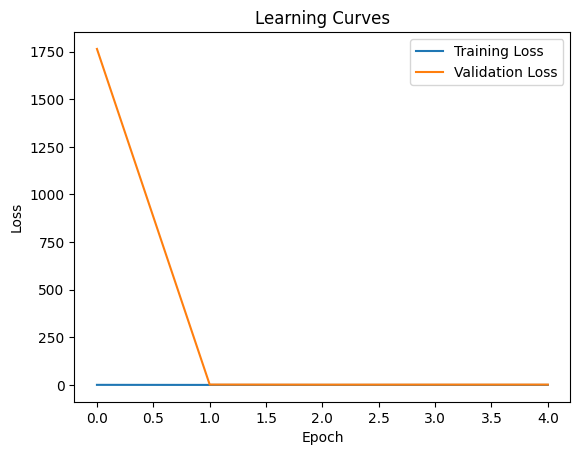

In [ ]:
# Display learning curves
plot_learning_curves(history)

### Visualize Predictions (1 points)

1/1 [==============================] - 2s 2s/step


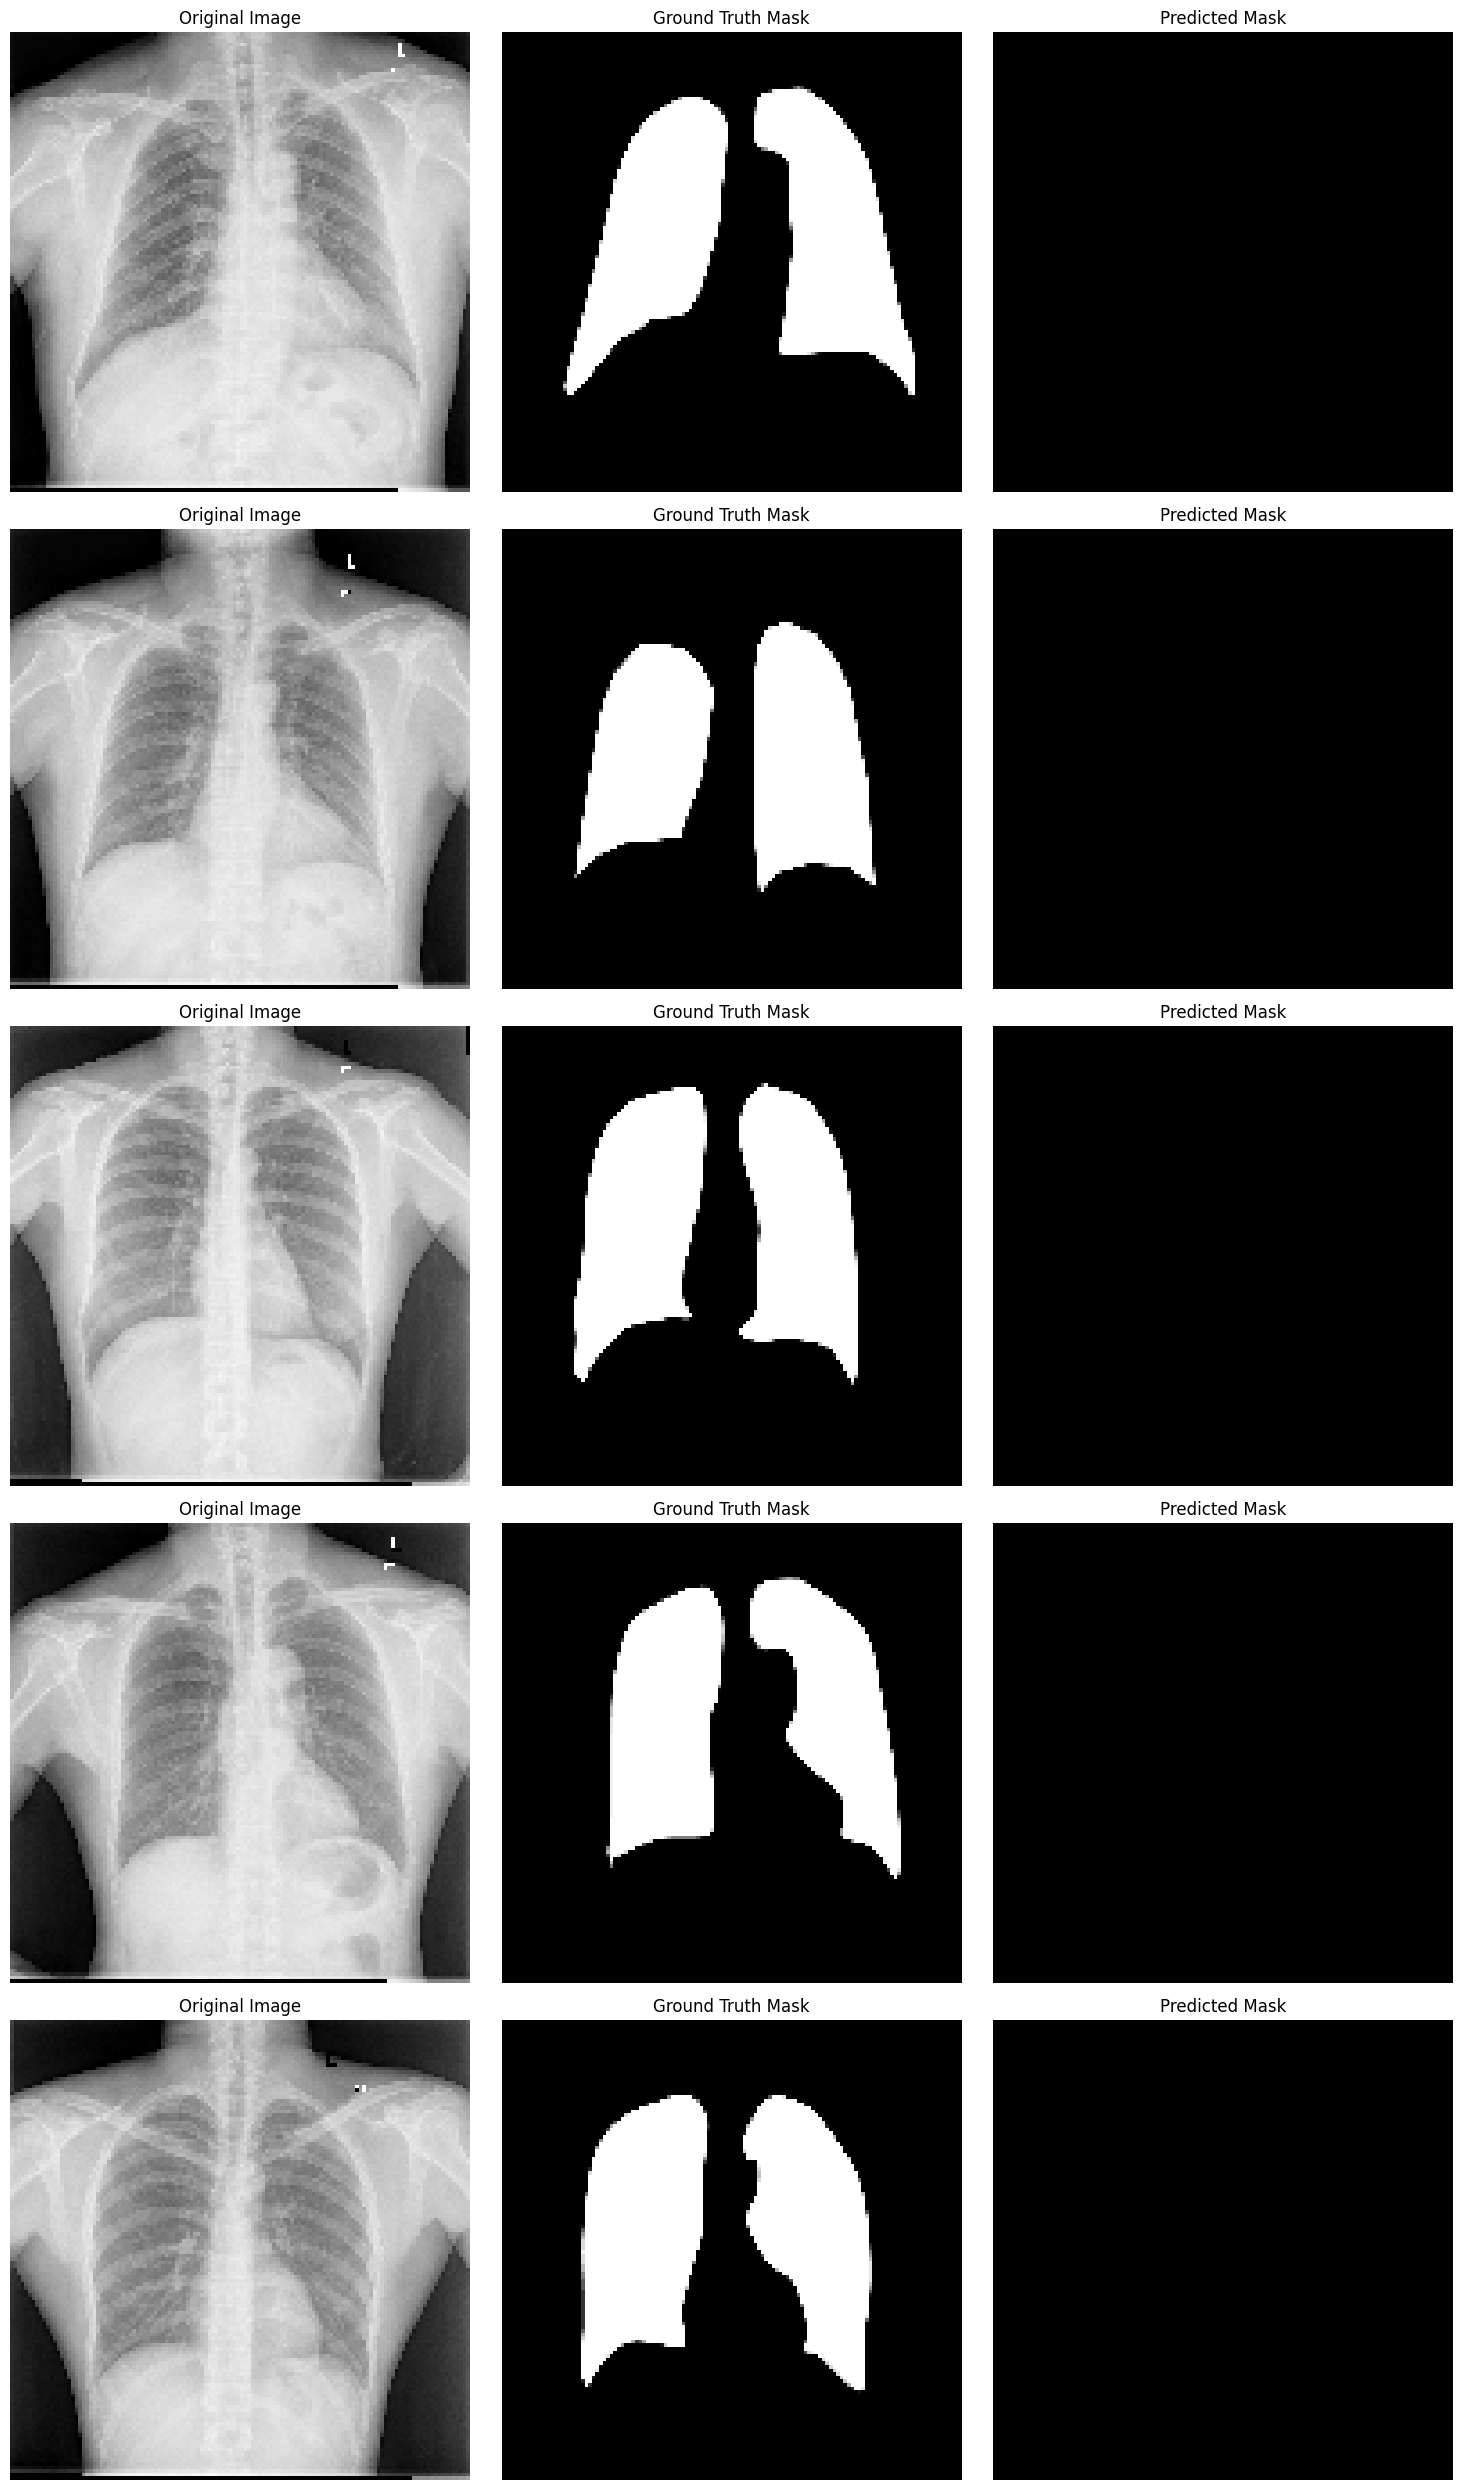

In [ ]:
# Visualization function
def visualize_predictions(model, images, masks, num_samples=5):
    predictions = model.predict(images[:num_samples])
    predictions = tf.argmax(predictions, axis=-1)
    predictions = predictions.numpy()

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    for i in range(num_samples):
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(masks[i].squeeze(), cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(predictions[i], cmap='gray')
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Number of samples to visualize
num_samples = 5

# Ensure the number of samples does not exceed the size of the validation set
num_samples = min(num_samples, len(val_images))

# Visualize predictions
visualize_predictions(model, val_images, val_masks, num_samples=num_samples)

#### Plot the predictions

10/10 [==============================] - 0s 2ms/step


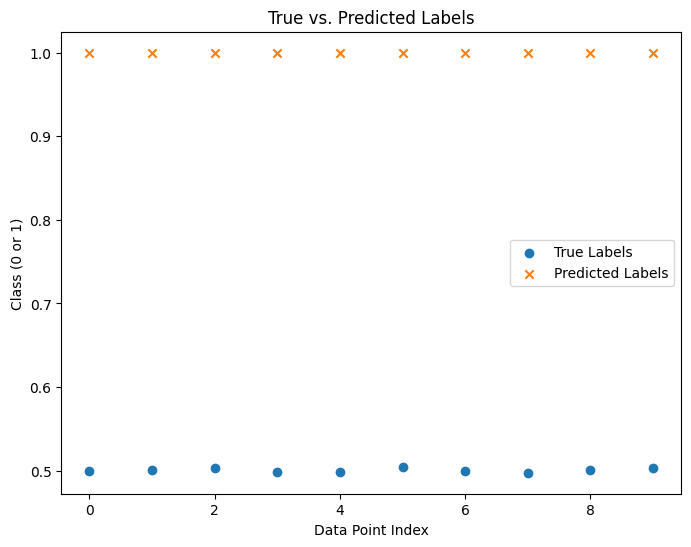

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf # Import tensorflow
# --- Replace '...' with your actual validation data ---
# Example:
val_images = np.random.rand(10, 128, 128, 3)  # Replace with your validation image data
val_labels = np.random.randint(0, 2, (10, 128, 128, 1)) # Replace with your validation label data
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

# --- Define or load your model here ---
# Example for a simple sequential model:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Adjust the number of units and activation based on your task
])

# If you have a saved model, load it:
 #model = tf.keras.models.load_model('/content/deeplabv3plus_model.h5')

# --- Get predictions from the model ---
# Resize images in the validation dataset to match the expected input shape
resized_val_dataset = val_dataset.map(lambda image, label: (tf.image.resize(image, (128, 128)), label))

# Add a batch dimension to the dataset
resized_val_dataset = resized_val_dataset.batch(1) # Adjust batch size as needed

predictions = model.predict(resized_val_dataset)  # Use the resized dataset

# --- Adapt this section based on your data and model ---
# Example assuming 'predictions' is for a binary classification problem
predicted_classes = np.round(predictions).flatten()

# Extract true labels - assuming labels are in the second element of each dataset tuple
true_classes = np.concatenate([label for _, label in resized_val_dataset.as_numpy_iterator()])

# Reshape or process true_classes to match the shape of predicted_classes
# For example, if each image has a single label, you might average the label image:
true_classes = np.mean(true_classes, axis=(1, 2)).flatten()  # Average over image dimensions

# --- Plotting ---
plt.figure(figsize=(8, 6))

# Example for binary classification - adjust as needed
plt.scatter(range(len(true_classes)), true_classes, label="True Labels", marker='o')
plt.scatter(range(len(predicted_classes)), predicted_classes, label="Predicted Labels", marker='x')

plt.xlabel("Data Point Index")
plt.ylabel("Class (0 or 1)")
plt.title("True vs. Predicted Labels")
plt.legend()
plt.show()